In [1]:
import sys
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

sys.path.append(str(Path("..").resolve()))
from src import *

# Generating validity masks for UVs

Currently, in the CNet training, the loss is computed as the MSE between the predicted and the ground truth texture like this:

```python
F.mse_loss(model_pred.float(), target.float(), reduction="mean")
```

This means that the loss considers all parts of the texture equally. However, parts that are not mapped in the UV should not affect training.

In this notebook we generate UV masks for the dataset in the `dataset/` folder.

In [2]:
DATASET_DIR = Path("dataset")
splits = list(DATASET_DIR.glob("*/"))
folders = (DATASET_DIR / splits[0]).glob("*/")

In [3]:
dataset = ObjaverseDataset3D()

## How are we going to export the masks?
Masks are exported as a numpy `ndarray` and packed using `packbits()` to achieve a $\approx 250 \times$ compression.

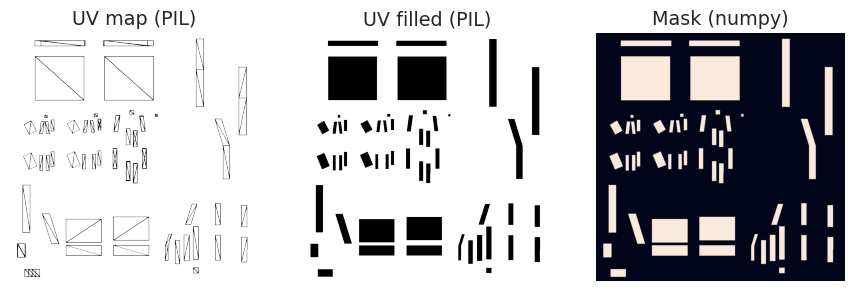

In [77]:
obj = dataset["4f2b29543a1e49ae9ff18c37e9069151"]
uv, uv_filled = obj.draw_uv_map(stroke=3), obj.draw_uv_map(fill=True)
mask = np.alltrue(np.array(uv_filled) == [0, 0, 0, 255], axis=2)
plot_images({"UV map (PIL)": uv, "UV filled (PIL)": uv_filled, "Mask (numpy)": mask})

In [ ]:
for split in splits:
    cprint("Processing", f"yellow:{split.name}:")
    mask_dir = split / "mask"
    mask_dir.mkdir(exist_ok=True)
    uids = [uv.stem for uv in (split / "uv").glob("*.png") if not (mask_dir / f"{uv.stem}.npy").exists()]

    # Load metadata CSV and set UIDs as indexes
    metadata = pd.read_csv(split / "metadata.csv")
    metadata.index = pd.Series(metadata.uv_file_name.map(lambda x: Path(x).stem), name="uid")
    metadata["mask_file_name"] = ""

    for uid in tqdm(uids):
        obj = dataset[uid]
        uv_filled = obj.draw_uv_map(fill=True)
        mask = np.alltrue(np.array(uv_filled) == [0, 0, 0, 255], axis=2)
        np.save(mask_dir / f"{uid}.npy", np.packbits(mask))
        metadata.loc[uid, "mask_file_name"] = f"mask/{uid}.npy"
        
    metadata.to_csv(split / "metadata.csv", index=False)

## How to read the masks back?
Since they're packed, we need to call the `unpackbits` function and to `reshape` them back.

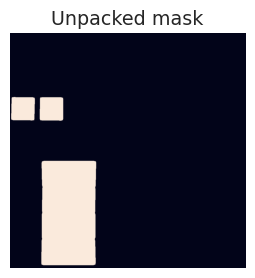

In [93]:
mask = np.unpackbits(np.load("dataset/validation/mask/0cde463ba5d64acd979ab2d4e31fded0.npy")).reshape((1024, 1024))
plot_images({'Unpacked mask':mask})